In [57]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import xesmf as xe 
import sys
import os
import dask

In [58]:
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]

In [59]:
len(models)

18

### rcp85

BNU-ESM
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-CC365
HadGEM2-ES365
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM-CHEM
MIROC-ESM
MIROC5
bcc-csm1-1-m
MRI-CGCM3
bcc-csm1-1
inmcm4


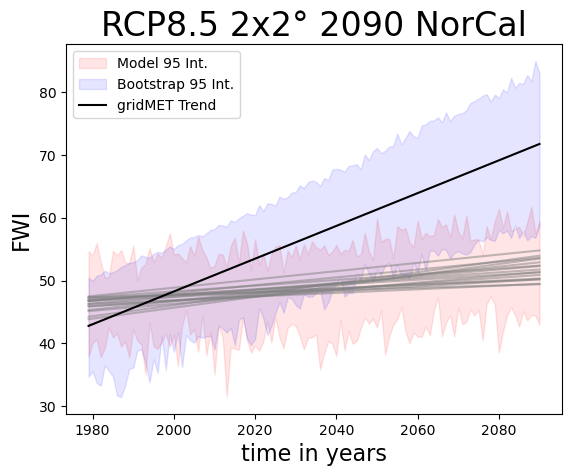

In [63]:
# The following until the # line is all just plotting the original trend, and slope etc. 
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)
region = 'NorCal'
lon_max = -121
lon_min = -123
lat_min = 38.5
lat_max = 40.5

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')

spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI

trendline_values = trend_slope * spatial_aggregate["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]
    

###############################################################################################################################################
x_values_scatter = np.linspace(1979, 2023, 44) 
x_values_trend = np.linspace(1979, 2090, 112) 

model_array_for_confidence = []
for model in models:
    filein = f"/data/rsriver/a/ctavila2/FWI_cleaned/time_series/{region}_macav2metdata_fwi_{model}_r1i1p1_rcp8.5_tmaxrhmin_1979_2090_timeseries.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2090'))
    model_array_for_confidence.append(current_model.FWI.values)
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    plt.plot(current_model.year, trend, color='gray', alpha=.5)


# this is confidence interval for the model data
top_bounds_percentile = np.nanpercentile(model_array_for_confidence, 97.5, axis=0)
btm_bounds_percentile = np.nanpercentile(model_array_for_confidence, 2.5, axis=0)

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Model 95 Int.", color='r', alpha=.1)

# below is confidence interval for the observational data
filein_confidence = f'/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_{region}_Confidence_Interval_95th'
confidence_dataset = xr.open_dataset(filein_confidence)

plt.fill_between(x_values_trend, confidence_dataset.top_bounds, confidence_dataset.btm_bounds, label="Bootstrap 95 Int.", color='b', alpha=.1)


#plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3.5)
plt.plot(x_values_trend, length, color='black', label='gridMET Trend')
plt.legend(loc='upper left')
plt.title(f'RCP8.5 2x2° 2090 {region}', fontsize=24)
plt.xlabel('time in years', fontsize = 16)
plt.ylabel('FWI', fontsize = 16)
plt.savefig(f"/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/RCP8.5_2060_{region}_confidence_interval.png")

BNU-ESM
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-CC365
HadGEM2-ES365
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM-CHEM
MIROC-ESM
MIROC5
bcc-csm1-1-m
MRI-CGCM3
bcc-csm1-1
inmcm4


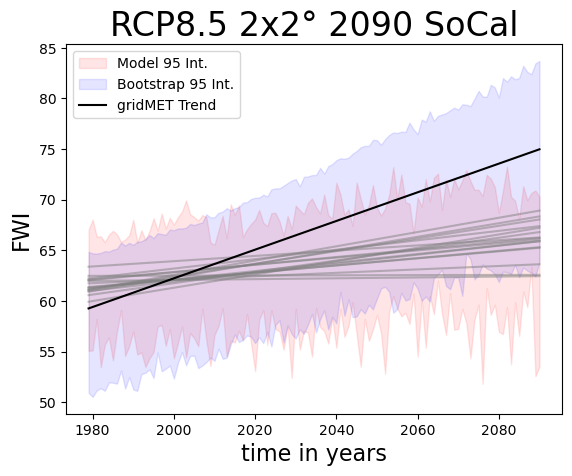

In [64]:
# The following until the # line is all just plotting the original trend, and slope etc. 
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)
region = 'SoCal'
lon_max = -116.5
lon_min = -118.5
lat_min = 34
lat_max = 36

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')

spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI

trendline_values = trend_slope * spatial_aggregate["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]
    

###############################################################################################################################################
x_values_scatter = np.linspace(1979, 2023, 44) 
x_values_trend = np.linspace(1979, 2090, 112) 

model_array_for_confidence = []
for model in models:
    filein = f"/data/rsriver/a/ctavila2/FWI_cleaned/time_series/{region}_macav2metdata_fwi_{model}_r1i1p1_rcp8.5_tmaxrhmin_1979_2090_timeseries.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2090'))
    model_array_for_confidence.append(current_model.FWI.values)
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    plt.plot(current_model.year, trend, color='gray', alpha=.5)


# this is confidence interval for the model data
top_bounds_percentile = np.nanpercentile(model_array_for_confidence, 97.5, axis=0)
btm_bounds_percentile = np.nanpercentile(model_array_for_confidence, 2.5, axis=0)

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Model 95 Int.", color='r', alpha=.1)

# below is confidence interval for the observational data
filein_confidence = f'/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_{region}_Confidence_Interval_95th'
confidence_dataset = xr.open_dataset(filein_confidence)

plt.fill_between(x_values_trend, confidence_dataset.top_bounds, confidence_dataset.btm_bounds, label="Bootstrap 95 Int.", color='b', alpha=.1)


#plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3.5)
plt.plot(x_values_trend, length, color='black', label='gridMET Trend')
plt.legend(loc='upper left')
plt.title(f'RCP8.5 2x2° 2090 {region}', fontsize=24)
plt.xlabel('time in years', fontsize = 16)
plt.ylabel('FWI', fontsize = 16)
plt.savefig(f"/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/RCP8.5_2060_{region}_confidence_interval.png")

### rcp45

BNU-ESM
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-CC365
HadGEM2-ES365
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM-CHEM
MIROC-ESM
MIROC5
bcc-csm1-1-m
MRI-CGCM3
bcc-csm1-1
inmcm4


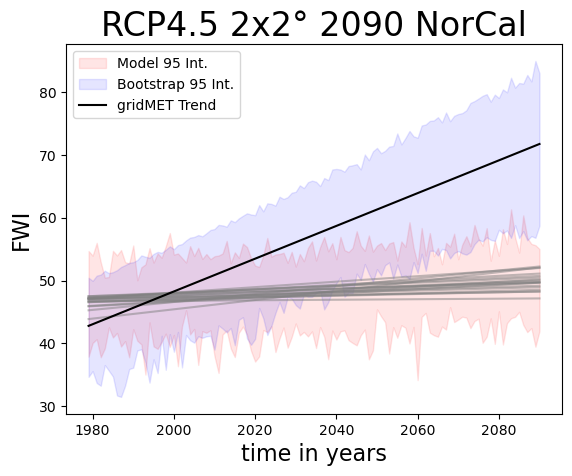

In [65]:
# The following until the # line is all just plotting the original trend, and slope etc. 
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)
region = 'NorCal'
lon_max = -121
lon_min = -123
lat_min = 38.5
lat_max = 40.5

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')

spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI

trendline_values = trend_slope * spatial_aggregate["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]
    

###############################################################################################################################################
x_values_scatter = np.linspace(1979, 2023, 44) 
x_values_trend = np.linspace(1979, 2090, 112) 

model_array_for_confidence = []
for model in models:
    filein = f"/data/rsriver/a/ctavila2/FWI_cleaned/time_series/{region}_macav2metdata_fwi_{model}_r1i1p1_rcp4.5_tmaxrhmin_1979_2090_timeseries.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2090'))
    model_array_for_confidence.append(current_model.FWI.values)
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    plt.plot(current_model.year, trend, color='gray', alpha=.5)


# this is confidence interval for the model data
top_bounds_percentile = np.nanpercentile(model_array_for_confidence, 97.5, axis=0)
btm_bounds_percentile = np.nanpercentile(model_array_for_confidence, 2.5, axis=0)

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Model 95 Int.", color='r', alpha=.1)

# below is confidence interval for the observational data
filein_confidence = f'/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_{region}_Confidence_Interval_95th'
confidence_dataset = xr.open_dataset(filein_confidence)

plt.fill_between(x_values_trend, confidence_dataset.top_bounds, confidence_dataset.btm_bounds, label="Bootstrap 95 Int.", color='b', alpha=.1)


#plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3.5)
plt.plot(x_values_trend, length, color='black', label='gridMET Trend')
plt.legend(loc='upper left')
plt.title(f'RCP4.5 2x2° 2090 {region}', fontsize=24)
plt.xlabel('time in years', fontsize = 16)
plt.ylabel('FWI', fontsize = 16)
plt.savefig(f"/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/RCP4.5_2060_{region}_confidence_interval.png")

BNU-ESM
CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-CC365
HadGEM2-ES365
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM-CHEM
MIROC-ESM
MIROC5
bcc-csm1-1-m
MRI-CGCM3
bcc-csm1-1
inmcm4


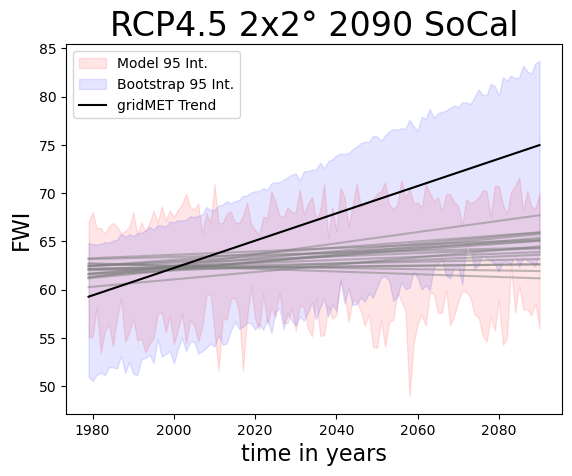

In [66]:
# The following until the # line is all just plotting the original trend, and slope etc. 
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)
region = 'SoCal'
lon_max = -116.5
lon_min = -118.5
lat_min = 34
lat_max = 36

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')

spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI

trendline_values = trend_slope * spatial_aggregate["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

values_array_for_plot_original = []
length = np.linspace(1979, 2090, 112) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]
    

###############################################################################################################################################
x_values_scatter = np.linspace(1979, 2023, 44) 
x_values_trend = np.linspace(1979, 2090, 112) 

model_array_for_confidence = []
for model in models:
    filein = f"/data/rsriver/a/ctavila2/FWI_cleaned/time_series/{region}_macav2metdata_fwi_{model}_r1i1p1_rcp4.5_tmaxrhmin_1979_2090_timeseries.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2090'))
    model_array_for_confidence.append(current_model.FWI.values)
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    plt.plot(current_model.year, trend, color='gray', alpha=.5)


# this is confidence interval for the model data
top_bounds_percentile = np.nanpercentile(model_array_for_confidence, 97.5, axis=0)
btm_bounds_percentile = np.nanpercentile(model_array_for_confidence, 2.5, axis=0)

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="Model 95 Int.", color='r', alpha=.1)

# below is confidence interval for the observational data
filein_confidence = f'/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_{region}_Confidence_Interval_95th'
confidence_dataset = xr.open_dataset(filein_confidence)

plt.fill_between(x_values_trend, confidence_dataset.top_bounds, confidence_dataset.btm_bounds, label="Bootstrap 95 Int.", color='b', alpha=.1)


#plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3.5)
plt.plot(x_values_trend, length, color='black', label='gridMET Trend')
plt.legend(loc='upper left')
plt.title(f'RCP4.5 2x2° 2090 {region}', fontsize=24)
plt.xlabel('time in years', fontsize = 16)
plt.ylabel('FWI', fontsize = 16)
plt.savefig(f"/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_3_socal_norcal_future_fwi_v2/RCP4.5_2060_{region}_confidence_interval.png")